![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)



[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Public/3.SparkNLP_Pretrained_Models.ipynb)

# 3. Spark NLP Pretrained Models

Spark NLP offers the following pre-trained models in five languages (English, French, German, Italian, Russia) and all you need to do is to load the pre-trained model into your disk by specifying the model name and then configuring the model parameters as per your use case and dataset. Then you will not need to worry about training a new model from scratch and will be able to enjoy the pre-trained SOTA algorithms directly applied to your own data with transform().

In the official documentation, you can find detailed information regarding how these models are trained by using which algorithms and datasets.

https://github.com/JohnSnowLabs/spark-nlp-models

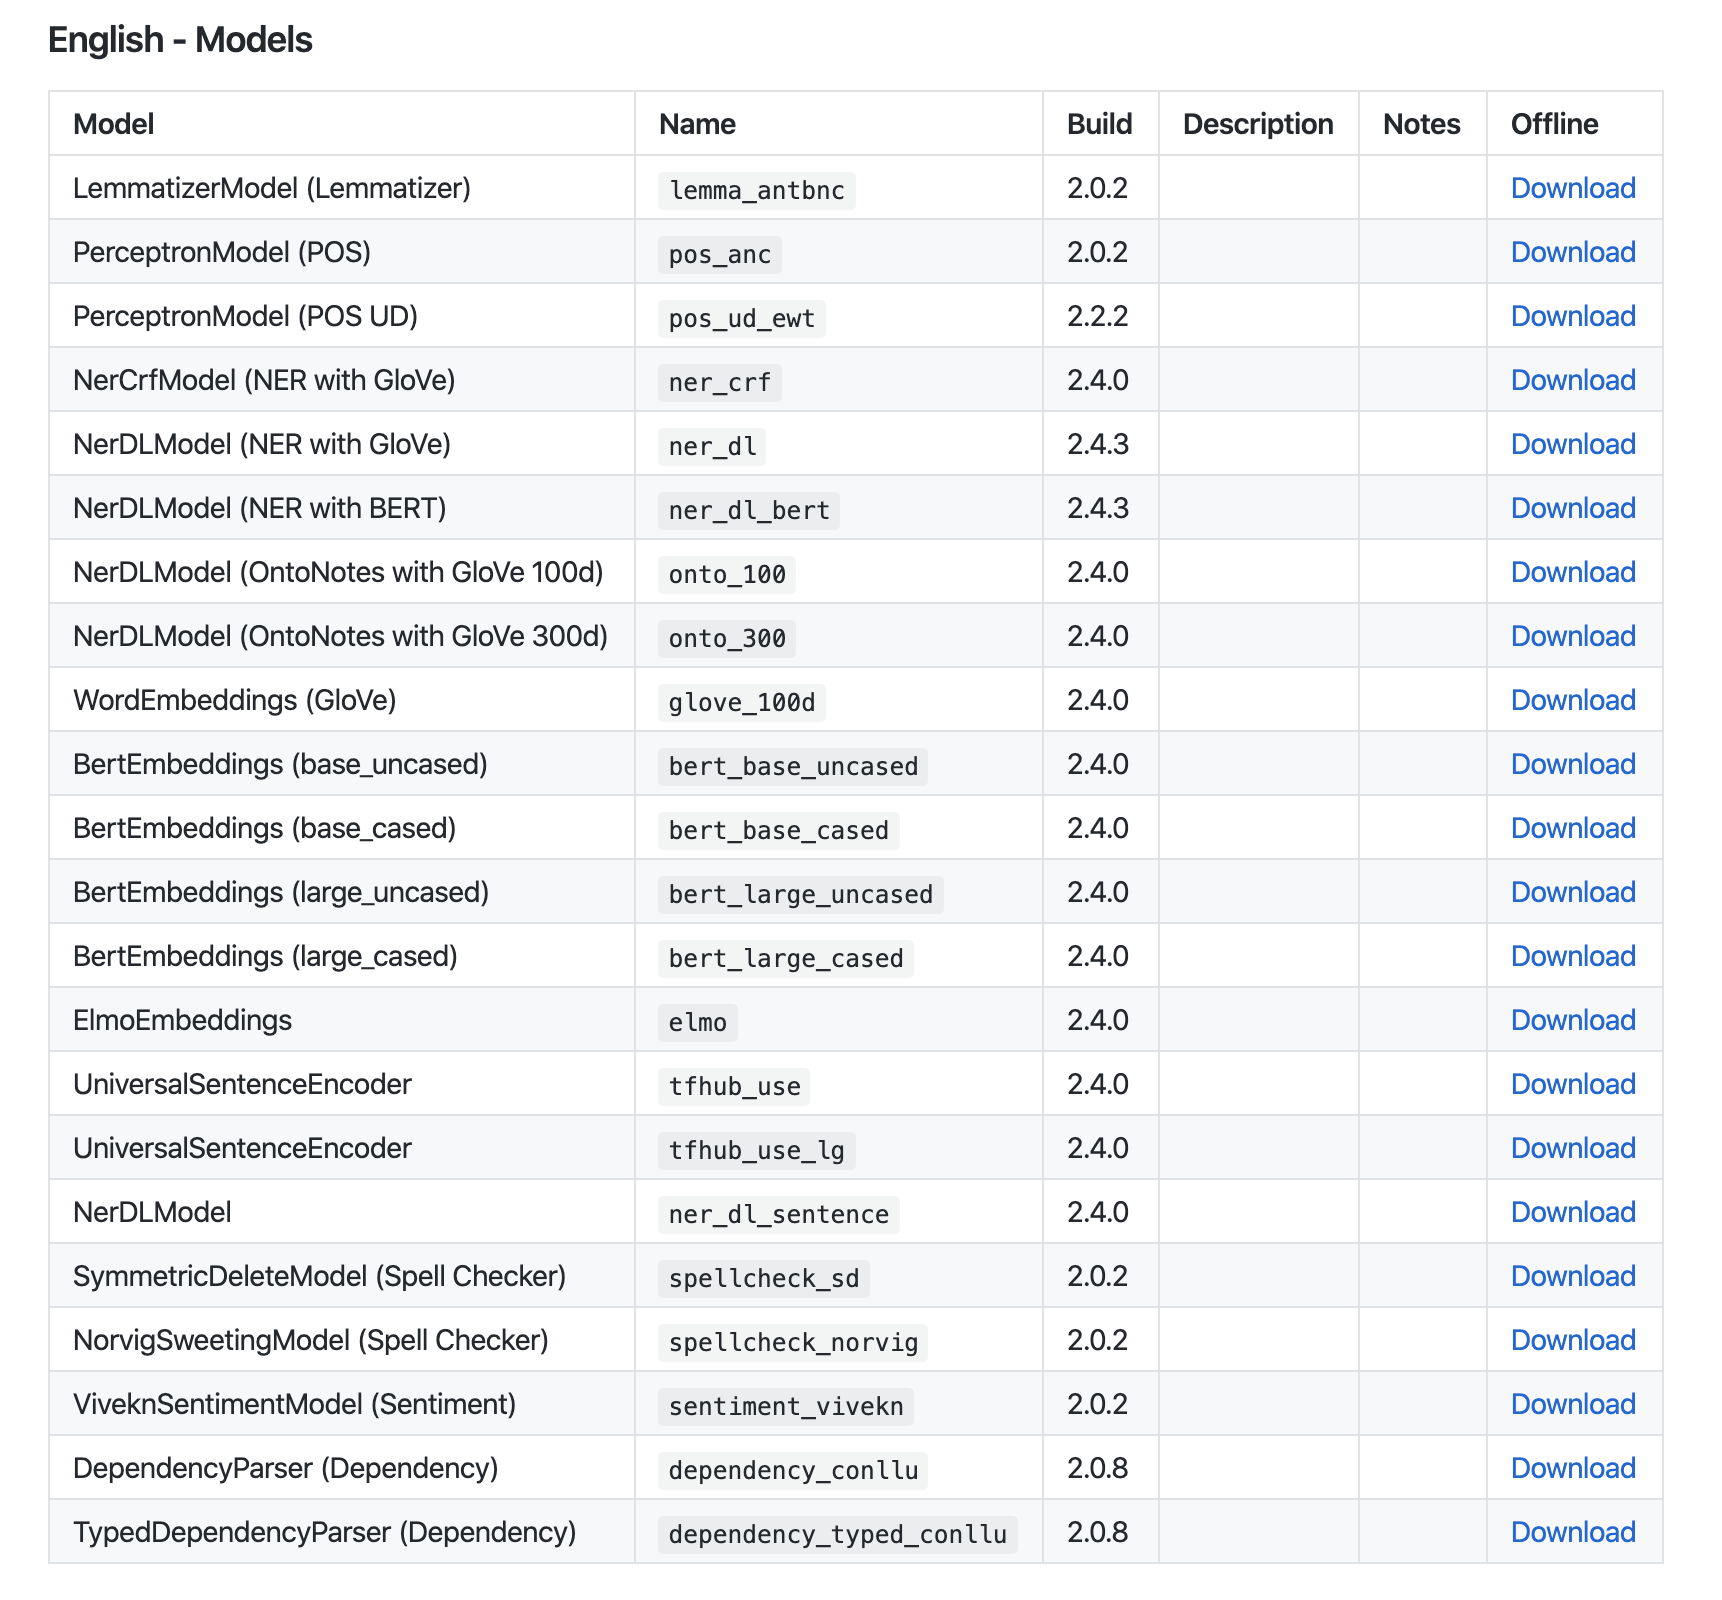

## 0. Colab Setup

In [ ]:
import os

# Install java
! apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]
! java -version

# Install pyspark
! pip install --ignore-installed -q pyspark==2.4.4

# Install Spark NLP
! pip install --ignore-installed -q spark-nlp==2.4.5

openjdk version "1.8.0_242"
OpenJDK Runtime Environment (build 1.8.0_242-8u242-b08-0ubuntu3~18.04-b08)
OpenJDK 64-Bit Server VM (build 25.242-b08, mixed mode)
     |████████████████████████████████| 215.7MB 63kB/s 
     |████████████████████████████████| 204kB 40.2MB/s 
     |████████████████████████████████| 112kB 1.4MB/s 


In [1]:
import sparknlp

spark = sparknlp.start()

from sparknlp.base import *
from sparknlp.annotator import *

print("Spark NLP version", sparknlp.version())

print("Apache Spark version:", spark.version)

spark

Spark NLP version 2.4.4
Apache Spark version: 2.4.4


## LemmatizerModel

In [2]:
!wget -O news_category_test.csv https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/classifier-dl/news_Category/news_category_test.csv

--2020-04-08 15:33:14--  https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/classifier-dl/news_Category/news_category_test.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.131.5
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.131.5|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1504408 (1.4M) [text/csv]
Saving to: ‘news_category_test.csv’

news_category_test. 100%[===================>]   1.43M  1.91MB/s    in 0.8s    

2020-04-08 15:33:15 (1.91 MB/s) - ‘news_category_test.csv’ saved [1504408/1504408]



In [3]:
import pyspark.sql.functions as F

news_df = spark.read\
                .option("header", "true")\
                .csv("news_category_test.csv")\
                .withColumnRenamed("description", "text")

news_df.show(truncate=50)

+--------+--------------------------------------------------+
|category|                                              text|
+--------+--------------------------------------------------+
|Business|Unions representing workers at Turner   Newall ...|
|Sci/Tech| TORONTO, Canada    A second team of rocketeers...|
|Sci/Tech| A company founded by a chemistry researcher at...|
|Sci/Tech| It's barely dawn when Mike Fitzpatrick starts ...|
|Sci/Tech| Southern California's smog fighting agency wen...|
|Sci/Tech|"The British Department for Education and Skill...|
|Sci/Tech|"confessed author of the Netsky and Sasser viru...|
|Sci/Tech|\\FOAF/LOAF  and bloom filters have a lot of in...|
|Sci/Tech|"Wiltshire Police warns about ""phishing"" afte...|
|Sci/Tech|In its first two years, the UK's dedicated card...|
|Sci/Tech| A group of technology companies  including Tex...|
|Sci/Tech| Apple Computer Inc.&lt;AAPL.O&gt; on  Tuesday ...|
|Sci/Tech| Free Record Shop, a Dutch music  retail chain,...|
|Sci/Tec

In [ ]:
lemmatizer = LemmatizerModel.pretrained('lemma_antbnc', 'en') \
    .setInputCols(["token"]) \
    .setOutputCol("lemma") \


'''
lemmatizer = Lemmatizer() \
    .setInputCols(["token"]) \
    .setOutputCol("lemma") \
    .setDictionary("./AntBNC_lemmas_ver_001.txt", value_delimiter ="\t", key_delimiter = "->")
'''

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


In [ ]:
!cd ~/cache_pretrained && ls -l


total 8
drwxr-xr-x 4 root root 4096 Apr  7 10:55 lemma_antbnc_en_2.0.2_2.4_1556480454569
drwxr-xr-x 4 root root 4096 Apr  7 11:09 pos_anc_en_2.0.2_2.4_1556659930154


In [ ]:
from pyspark.ml import Pipeline

documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")

stemmer = Stemmer() \
    .setInputCols(["token"]) \
    .setOutputCol("stem")

nlpPipeline = Pipeline(stages=[
 documentAssembler, 
 tokenizer,
 stemmer,
 lemmatizer
 ])

empty_df = spark.createDataFrame([['']]).toDF("text")

pipelineModel = nlpPipeline.fit(empty_df)


In [ ]:
result = pipelineModel.transform(news_df)

result.show(5)

+--------+--------------------+--------------------+--------------------+--------------------+--------------------+
|category|                text|            document|               token|                stem|               lemma|
+--------+--------------------+--------------------+--------------------+--------------------+--------------------+
|Business|Unions representi...|[[document, 0, 12...|[[token, 0, 5, Un...|[[token, 0, 5, un...|[[token, 0, 5, Un...|
|Sci/Tech| TORONTO, Canada ...|[[document, 0, 22...|[[token, 1, 7, TO...|[[token, 1, 7, to...|[[token, 1, 7, TO...|
|Sci/Tech| A company founde...|[[document, 0, 20...|[[token, 1, 1, A,...|[[token, 1, 1, a,...|[[token, 1, 1, A,...|
|Sci/Tech| It's barely dawn...|[[document, 0, 26...|[[token, 1, 4, It...|[[token, 1, 4, it...|[[token, 1, 4, It...|
|Sci/Tech| Southern Califor...|[[document, 0, 17...|[[token, 1, 8, So...|[[token, 1, 8, so...|[[token, 1, 8, So...|
+--------+--------------------+--------------------+--------------------

In [ ]:
result.select('token.result','lemma.result').show(5, truncate=100)

+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|                                                                                              result|                                                                                              result|
+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|[Unions, representing, workers, at, Turner, Newall, say, they, are, ', disappointed, ', after, ta...|[Unions, represent, worker, at, Turner, Newall, say, they, be, ', disappointed, ', after, talk, w...|
|[TORONTO, ,, Canada, A, second, team, of, rocketeers, competing, for, the, #36;10, million, Ansar...|[TORONTO, ,, Canada, A, second, team, of, rocketeer, compete, for, the, #36;10, mi

## PerceptronModel (POS - Part of speech tags)

In [ ]:
pos = PerceptronModel.pretrained("pos_anc", 'en')\
      .setInputCols("document", "token")\
      .setOutputCol("pos")

pos_anc download started this may take some time.
Approximate size to download 4.3 MB
[OK!]


In [ ]:
!cd ~/cache_pretrained && ls -l


total 8
drwxr-xr-x 4 root root 4096 Apr  7 10:55 lemma_antbnc_en_2.0.2_2.4_1556480454569
drwxr-xr-x 4 root root 4096 Apr  7 11:09 pos_anc_en_2.0.2_2.4_1556659930154


In [ ]:
nlpPipeline = Pipeline(stages=[
 documentAssembler, 
 tokenizer,
 stemmer,
 lemmatizer,
 pos
 ])

empty_df = spark.createDataFrame([['']]).toDF("text")

pipelineModel = nlpPipeline.fit(empty_df)


In [ ]:
result = pipelineModel.transform(news_df)

result.show(5)

+--------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|category|                text|            document|               token|                stem|               lemma|                 pos|
+--------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|Business|Unions representi...|[[document, 0, 12...|[[token, 0, 5, Un...|[[token, 0, 5, un...|[[token, 0, 5, Un...|[[pos, 0, 5, NNP,...|
|Sci/Tech| TORONTO, Canada ...|[[document, 0, 22...|[[token, 1, 7, TO...|[[token, 1, 7, to...|[[token, 1, 7, TO...|[[pos, 1, 7, NNP,...|
|Sci/Tech| A company founde...|[[document, 0, 20...|[[token, 1, 1, A,...|[[token, 1, 1, a,...|[[token, 1, 1, A,...|[[pos, 1, 1, DT, ...|
|Sci/Tech| It's barely dawn...|[[document, 0, 26...|[[token, 1, 4, It...|[[token, 1, 4, it...|[[token, 1, 4, It...|[[pos, 1, 4, NNP,...|
|Sci/Tech| Southern Califor...|[[document

In [ ]:
result.select('token.result','pos.result').show(5, truncate=100)

+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|                                                                                              result|                                                                                              result|
+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|[Unions, representing, workers, at, Turner, Newall, say, they, are, ', disappointed, ', after, ta...|    [NNP, VBG, NNS, IN, NNP, NNP, VBP, PRP, VBP, POS, JJ, POS, IN, NNS, IN, NN, NN, NN, NNP, NNP, .]|
|[TORONTO, ,, Canada, A, second, team, of, rocketeers, competing, for, the, #36;10, million, Ansar...|[NNP, ,, NNP, DT, JJ, NN, IN, NNS, VBG, IN, DT, NN, CD, NNP, NNP, NNP, ,, DT, NN, 

In [ ]:
# applying this pipeline to top 100 rows and then converting to Pandas

result = pipelineModel.transform(news_df.limit(100))

result_df = result.select(F.explode(F.arrays_zip('token.result', 'token.begin', 'token.end', 'stem.result',  'lemma.result', 'pos.result')).alias("cols")) \
.select(F.expr("cols['0']").alias("token"),
        F.expr("cols['1']").alias("begin"),
        F.expr("cols['2']").alias("end"),
        F.expr("cols['3']").alias("stem"),
        F.expr("cols['4']").alias("lemma"),
        F.expr("cols['5']").alias("pos")).toPandas()

result_df.head(10) 

,token,begin,end,stem,lemma,pos
0,Unions,0,5,union,Unions,NNP
1,representing,7,18,repres,represent,VBG
2,workers,20,26,worker,worker,NNS
3,at,28,29,at,at,IN
4,Turner,31,36,turner,Turner,NNP
5,Newall,40,45,newal,Newall,NNP
6,say,47,49,sai,say,VBP
7,they,51,54,thei,they,PRP
8,are,56,58,ar,be,VBP
9,',60,60,',',POS


In [ ]:
# same in LightPipeline

light_model = LightPipeline(pipelineModel)

light_result = light_model.annotate('Unions representing workers at Turner   Newall say they are disappointed after talks with stricken parent firm Federal Mogul.')

list(zip(light_result['token'], light_result['stem'], light_result['lemma'], light_result['pos']))

[('Unions', 'union', 'Unions', 'NNP'),
 ('representing', 'repres', 'represent', 'VBG'),
 ('workers', 'worker', 'worker', 'NNS'),
 ('at', 'at', 'at', 'IN'),
 ('Turner', 'turner', 'Turner', 'NNP'),
 ('Newall', 'newal', 'Newall', 'NNP'),
 ('say', 'sai', 'say', 'VBP'),
 ('they', 'thei', 'they', 'PRP'),
 ('are', 'ar', 'be', 'VBP'),
 ('disappointed', 'disappoint', 'disappointed', 'VBN'),
 ('after', 'after', 'after', 'IN'),
 ('talks', 'talk', 'talk', 'NNS'),
 ('with', 'with', 'with', 'IN'),
 ('stricken', 'stricken', 'stricken', 'NN'),
 ('parent', 'parent', 'parent', 'NN'),
 ('firm', 'firm', 'firm', 'NN'),
 ('Federal', 'feder', 'Federal', 'NNP'),
 ('Mogul', 'mogul', 'Mogul', 'NNP'),
 ('.', '.', '.', '.')]

In [ ]:
# applying POS chunker to find a custom pattern

chunker = Chunker()\
    .setInputCols(["document", "pos"])\
    .setOutputCol("chunk")\
    .setRegexParsers(["<NNP>+", "<DT>?<JJ>*<NN>"])

# NNP: Proper Noun
# NN: COmmon Noun
# DT: Determinator (e.g. the)
# JJ: Adjective

nlpPipeline = Pipeline(stages=[
 documentAssembler, 
 tokenizer,
 stemmer,
 lemmatizer,
 pos,
 chunker
 ])

empty_df = spark.createDataFrame([['']]).toDF("text")

pipelineModel = nlpPipeline.fit(empty_df)

In [ ]:
result = pipelineModel.transform(news_df.limit(100))

result.show(5)

+--------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|category|                text|            document|               token|                stem|               lemma|                 pos|               chunk|
+--------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|Business|Unions representi...|[[document, 0, 12...|[[token, 0, 5, Un...|[[token, 0, 5, un...|[[token, 0, 5, Un...|[[pos, 0, 5, NNP,...|[[chunk, 0, 5, Un...|
|Sci/Tech| TORONTO, Canada ...|[[document, 0, 22...|[[token, 1, 7, TO...|[[token, 1, 7, to...|[[token, 1, 7, TO...|[[pos, 1, 7, NNP,...|[[chunk, 1, 7, TO...|
|Sci/Tech| A company founde...|[[document, 0, 20...|[[token, 1, 1, A,...|[[token, 1, 1, a,...|[[token, 1, 1, A,...|[[pos, 1, 1, DT, ...|[[chunk, 52, 61, ...|
|Sci/Tech| It's barely dawn...|[[document, 0, 26...|

In [ ]:

result_df = result.select(F.explode(F.arrays_zip('chunk.result', 'chunk.begin',  'chunk.end')).alias("cols")) \
.select(F.expr("cols['0']").alias("chunk"),
        F.expr("cols['1']").alias("begin"),
        F.expr("cols['2']").alias("end")).toPandas()

result_df.head(10)

,chunk,begin,end
0,Unions,0,5
1,Turner Newall,31,45
2,Federal Mogul,113,125
3,stricken,92,99
4,parent,101,106
5,firm,108,111
6,TORONTO,1,7
7,Canada,10,15
8,Ansari X Prize,82,95
9,A second team,20,32


## Dependency Parser



In [ ]:
dep_parser = DependencyParserModel.pretrained('dependency_conllu')\
        .setInputCols(["document", "pos", "token"])\
        .setOutputCol("dependency")

dependency_conllu download started this may take some time.
Approximate size to download 16.6 MB
[OK!]


In [ ]:
typed_dep_parser = TypedDependencyParserModel.pretrained('dependency_typed_conllu')\
        .setInputCols(["token", "pos", "dependency"])\
        .setOutputCol("dependency_type")

dependency_typed_conllu download started this may take some time.
Approximate size to download 257.4 KB
[OK!]


In [ ]:
nlpPipeline = Pipeline(stages=[
 documentAssembler, 
 tokenizer,
 stemmer,
 lemmatizer,
 pos,
 dep_parser,
 typed_dep_parser
 ])

empty_df = spark.createDataFrame([['']]).toDF("text")

pipelineModel = nlpPipeline.fit(empty_df)

In [ ]:
result = pipelineModel.transform(news_df.limit(100))

result_df = result.select(F.explode(F.arrays_zip('token.result', 'token.begin',  'token.end', 'dependency.result', 'dependency_type.result')).alias("cols")) \
.select(F.expr("cols['0']").alias("chunk"),
        F.expr("cols['1']").alias("begin"),
        F.expr("cols['2']").alias("end"),
        F.expr("cols['3']").alias("dependency"),
        F.expr("cols['4']").alias("dependency_type")).toPandas()

result_df.head(10)

,chunk,begin,end,dependency,dependency_type
0,Unions,0,5,ROOT,root
1,representing,7,18,workers,amod
2,workers,20,26,Unions,flat
3,at,28,29,Turner,case
4,Turner,31,36,workers,flat
5,Newall,40,45,say,nsubj
6,say,47,49,Unions,parataxis
7,they,51,54,disappointed,nsubj
8,are,56,58,disappointed,nsubj
9,',60,60,disappointed,case


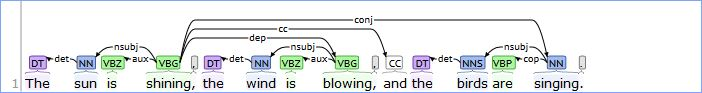

## SpellChecker

In [ ]:
spell_checker = NorvigSweetingModel.pretrained('spellcheck_norvig')\
        .setInputCols("token")\
        .setOutputCol("corrected")


spellcheck_norvig download started this may take some time.
Approximate size to download 4.2 MB
[OK!]


In [ ]:
nlpPipeline = Pipeline(stages=[
 documentAssembler, 
 tokenizer,
 stemmer,
 lemmatizer,
 pos,
 spell_checker
 ])

empty_df = spark.createDataFrame([['']]).toDF("text")

pipelineModel = nlpPipeline.fit(empty_df)

In [ ]:
result = pipelineModel.transform(news_df.limit(100))


In [ ]:

result_df = result.select(F.explode(F.arrays_zip('token.result', 'corrected.result', 'stem.result',  'lemma.result', 'pos.result')).alias("cols")) \
.select(F.expr("cols['0']").alias("token"),
        F.expr("cols['1']").alias("corrected"),
        F.expr("cols['2']").alias("stem"),
        F.expr("cols['3']").alias("lemma"),
        F.expr("cols['4']").alias("pos")).toPandas()

result_df.head(10)

,token,corrected,stem,lemma,pos
0,Unions,Unions,union,Unions,NNP
1,representing,representing,repres,represent,VBG
2,workers,workers,worker,worker,NNS
3,at,at,at,at,IN
4,Turner,Turner,turner,Turner,NNP
5,Newall,Newell,newal,Newall,NNP
6,say,say,sai,say,VBP
7,they,they,thei,they,PRP
8,are,are,ar,be,VBP
9,',',',',POS


In [ ]:
# same in LightPipeline

light_model = LightPipeline(pipelineModel)

light_result = light_model.annotate('The patint has pain and headace')

list(zip(light_result['token'], light_result['corrected']))


[('The', 'The'),
 ('patint', 'patient'),
 ('has', 'has'),
 ('pain', 'pain'),
 ('and', 'and'),
 ('headace', 'headache')]

## Word Embeddings (Glove)

In [ ]:
glove_embeddings = WordEmbeddingsModel.pretrained('glove_100d')\
          .setInputCols(["document", "token"])\
          .setOutputCol("embeddings")
    

glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[OK!]


In [ ]:
nlpPipeline = Pipeline(stages=[
 documentAssembler, 
 tokenizer,
 glove_embeddings
 ])

empty_df = spark.createDataFrame([['']]).toDF("text")

pipelineModel = nlpPipeline.fit(empty_df)

In [ ]:
result = pipelineModel.transform(news_df.limit(10))


In [ ]:
result.select('embeddings.embeddings').take(1)

[Row(embeddings=[[0.7186499834060669, 0.8075399994850159, -1.1786999702453613, 0.271450012922287, -0.48833000659942627, -0.1893800050020218, -1.1789000034332275, 0.1783600002527237, -0.21995000541210175, -0.7215999960899353, -0.5354200005531311, -0.7507500052452087, 0.41176000237464905, 0.18951000273227692, -0.5093500018119812, -0.735010027885437, 0.33823999762535095, 0.3451400101184845, -0.16735999286174774, 0.130390003323555, 1.1055999994277954, 0.5508400201797485, -0.01406800001859665, -0.5322800278663635, -0.23598000407218933, -1.0496000051498413, -0.6549199819564819, -0.17997999489307404, 0.10341999679803848, -0.315530002117157, 0.31481000781059265, 0.8438799977302551, 0.305400013923645, -1.158400058746338, 0.047777000814676285, -0.04945499822497368, 0.7908999919891357, -0.22619999945163727, -0.6294800043106079, 0.3116999864578247, -0.7399600148200989, 0.1283400058746338, 0.10723999887704849, 0.3257099986076355, -0.2687300145626068, -0.70169997215271, 0.16669000685214996, 0.330889

In [ ]:
result = pipelineModel.transform(news_df.limit(10))

result_df = result.select(F.explode(F.arrays_zip('token.result', 'embeddings.embeddings')).alias("cols")) \
.select(F.expr("cols['0']").alias("token"),
        F.expr("cols['1']").alias("embeddings"))

result_df.show(10, truncate=100)

+------------+----------------------------------------------------------------------------------------------------+
|       token|                                                                                          embeddings|
+------------+----------------------------------------------------------------------------------------------------+
|      Unions|[0.71865, 0.80754, -1.1787, 0.27145, -0.48833, -0.18938, -1.1789, 0.17836, -0.21995, -0.7216, -0....|
|representing|[0.25671, 0.30035, -0.18006, 0.46666, 0.98501, 0.2321, -0.34959, 0.26997, -0.99667, -0.43404, -0....|
|     workers|[0.50592, 0.71717, -0.67236, -0.32112, -0.58285, -0.47977, -0.50243, 0.60594, 0.25709, 0.03974, -...|
|          at|[0.1766, 0.093851, 0.24351, 0.44313, -0.39037, 0.12524, -0.19918, 0.59855, -0.82035, 0.28006, 0.5...|
|      Turner|[0.51634, -0.37186, -0.21776, -1.0115, 0.4014, -0.4841, 0.36274, -0.2952, -0.42258, -0.62844, 0.6...|
|      Newall|[-0.38857, -1.1449, -0.41737, -0.31969, -0.16546, -0.7044,

## Elmo Embeddings

In [ ]:
elmo_embeddings = ElmoEmbeddings.pretrained('elmo')\
          .setInputCols(["document", "token"])\
          .setOutputCol("embeddings")
    

elmo download started this may take some time.
Approximate size to download 334.1 MB
[OK!]


In [ ]:
nlpPipeline = Pipeline(stages=[
 documentAssembler, 
 tokenizer,
 elmo_embeddings
 ])

empty_df = spark.createDataFrame([['']]).toDF("text")

pipelineModel = nlpPipeline.fit(empty_df)

result = pipelineModel.transform(news_df.limit(10))

result_df = result.select(F.explode(F.arrays_zip('token.result', 'embeddings.embeddings')).alias("cols")) \
.select(F.expr("cols['0']").alias("token"),
        F.expr("cols['1']").alias("elmo_embeddings"))

result_df.show(truncate=100)

+------------+----------------------------------------------------------------------------------------------------+
|       token|                                                                                     elmo_embeddings|
+------------+----------------------------------------------------------------------------------------------------+
|      Unions|[0.5389476, 0.4226915, -0.16224553, -0.1128005, -0.12524837, -0.28185326, 0.12341033, -0.22033125...|
|representing|[0.1591705, 0.95000935, -0.12492801, 0.9341251, 0.5854504, 0.7605221, -0.30143818, -0.3193327, -0...|
|     workers|[0.082813635, -0.17253807, -0.73114246, 0.56554866, 0.36294985, -0.42002633, 0.66982335, -0.71128...|
|          at|[-0.11999596, 0.01299414, -0.078183725, 0.037628517, -0.268691, 0.13629477, -0.27565888, 0.343611...|
|      Turner|[0.32819325, -0.11992816, 0.15701114, 0.560922, -0.2836563, -0.1923972, 0.04214704, 0.5058229, -0...|
|      Newall|[-0.17683865, -0.5143349, -0.45629728, -7.754117E-4, -0.35

## Bert Embeddings

In [ ]:
bert_embeddings = BertEmbeddings.pretrained('bert_base_uncased')\
          .setInputCols(["document", "token"])\
          .setOutputCol("embeddings")
    

bert_base_uncased download started this may take some time.
Approximate size to download 392.5 MB
[OK!]


In [ ]:
nlpPipeline = Pipeline(stages=[
 documentAssembler, 
 tokenizer,
 bert_embeddings
 ])

empty_df = spark.createDataFrame([['']]).toDF("text")

pipelineModel = nlpPipeline.fit(empty_df)

result = pipelineModel.transform(news_df.limit(10))

result_df = result.select(F.explode(F.arrays_zip('token.result', 'embeddings.embeddings')).alias("cols")) \
.select(F.expr("cols['0']").alias("token"),
        F.expr("cols['1']").alias("bert_embeddings"))

result_df.show(truncate=100)

+------------+----------------------------------------------------------------------------------------------------+
|       token|                                                                                     bert_embeddings|
+------------+----------------------------------------------------------------------------------------------------+
|      Unions|[0.3423483, -0.7621089, -0.95610934, -0.9080744, 0.03278944, -0.19068101, 0.06841645, 0.8715485, ...|
|representing|[-0.6609322, 0.36830586, -0.04385671, -0.062400907, -0.21250877, -0.3625311, -0.13388896, -9.9757...|
|     workers|[-0.49138808, -0.0533655, -1.1493174, -0.6050249, -0.7109844, 0.20254612, 0.53452104, -0.6757567,...|
|          at|[-0.59642524, 0.13935125, 0.09018701, -0.6268516, -0.75282824, 0.16119936, 0.10998525, 0.6566241,...|
|      Turner|[0.87067986, 0.6809796, 0.7334639, 0.03486839, 0.07190508, 0.5168021, 0.18955632, 0.76651955, 0.5...|
|      Newall|[0.17950639, -0.34025913, 0.25570604, 0.21317199, -0.33208

## UniversalSentenceEncoder

In [ ]:
# no need for token columns 
use_embeddings = UniversalSentenceEncoder.pretrained('tfhub_use').\
  setInputCols(["document"]).\
  setOutputCol("sentence_embeddings")

    

tfhub_use download started this may take some time.
ERROR! Session/line number was not unique in database. History logging moved to new session 64
Approximate size to download 923.7 MB
[OK!]


In [ ]:
nlpPipeline = Pipeline(stages=[
 documentAssembler, 
 use_embeddings
 ])

empty_df = spark.createDataFrame([['']]).toDF("text")

pipelineModel = nlpPipeline.fit(empty_df)

result = pipelineModel.transform(news_df.limit(10))

result_df = result.select(F.explode(F.arrays_zip('document.result', 'sentence_embeddings.embeddings')).alias("cols")) \
.select(F.expr("cols['0']").alias("document"),
        F.expr("cols['1']").alias("USE_embeddings"))

result_df.show(truncate=100)

+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|                                                                                            document|                                                                                      USE_embeddings|
+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stric...|[0.01299754, 0.019844763, -0.02462647, 0.039759073, -0.04424647, 0.01319757, 0.0786744, -0.053629...|
| TORONTO, Canada    A second team of rocketeers competing for the  #36;10 million Ansari X Prize,...|[0.0019999044, 0.051844064, -0.0440291, -5.932768E-4, -0.038505998, -0.02727945, 0

### Loading Models from local

In [ ]:
!cd ~/cache_pretrained && pwd

/root/cache_pretrained


In [ ]:
!cd ~/cache_pretrained && ls -l

total 36
drwxr-xr-x 4 root root 4096 Apr  7 12:52 bert_base_uncased_en_2.4.0_2.4_1580579889322
drwxr-xr-x 4 root root 4096 Apr  7 12:01 dependency_conllu_en_2.0.8_2.4_1561435004077
drwxr-xr-x 4 root root 4096 Apr  7 12:05 dependency_typed_conllu_en_2.0.8_2.4_1561473259215
drwxr-xr-x 3 root root 4096 Apr  7 12:48 elmo_en_2.4.0_2.4_1580488815299
drwxr-xr-x 4 root root 4096 Apr  7 12:13 glove_100d_en_2.4.0_2.4_1579690104032
drwxr-xr-x 4 root root 4096 Apr  7 10:55 lemma_antbnc_en_2.0.2_2.4_1556480454569
drwxr-xr-x 4 root root 4096 Apr  7 11:09 pos_anc_en_2.0.2_2.4_1556659930154
drwxr-xr-x 4 root root 4096 Apr  7 11:45 spellcheck_norvig_en_2.1.0_2.4_1563017660080
drwxr-xr-x 3 root root 4096 Apr  7 12:57 tfhub_use_en_2.4.4_2.4_1583158595769


In [ ]:
glove_embeddings = WordEmbeddingsModel.load('/root/cache_pretrained/glove_100d_en_2.4.0_2.4_1579690104032').\
  setInputCols(["document", 'token']).\
  setOutputCol("glove_embeddings")

    

### Using your own Word embeddings in Spark NLP

In [ ]:
custom_embeddings = WordEmbeddings()\
  .setInputCols(["sentence", "token"])\
  .setOutputCol("my_embeddings")\
  .setStoragePath('PubMed-shuffle-win-2.bin', "BINARY")\
  .setDimension(200)

## Getting Sentence Embeddings from Glove, Elmo and BERT

In [ ]:
glove_embeddings = WordEmbeddingsModel.pretrained('glove_100d')\
          .setInputCols(["document", "token"])\
          .setOutputCol("embeddings")

embeddingsSentence = SentenceEmbeddings() \
      .setInputCols(["document", "embeddings"]) \
      .setOutputCol("sentence_embeddings") \
      .setPoolingStrategy("AVERAGE") # or SUM


nlpPipeline = Pipeline(stages=[
 documentAssembler, 
 tokenizer,
 glove_embeddings,
 embeddingsSentence
 ])

empty_df = spark.createDataFrame([['']]).toDF("text")

pipelineModel = nlpPipeline.fit(empty_df)

result = pipelineModel.transform(news_df.limit(10))

result_df = result.select(F.explode(F.arrays_zip('document.result', 'sentence_embeddings.embeddings')).alias("cols")) \
.select(F.expr("cols['0']").alias("document"),
        F.expr("cols['1']").alias("sentence_embeddings"))

result_df.show(truncate=100)



glove_100d download started this may take some time.
[ | ]
[OK!]
+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|                                                                                            document|                                                                                 sentence_embeddings|
+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stric...|[0.06131713, 0.08552574, 0.1340617, -0.22403374, -0.23798925, -0.159222, -0.21079227, 0.07760903,...|
| TORONTO, Canada    A second team of rocketeers competing for the  #36;10 million Ansari X Prize,...|[-0.05313636, 0.1

### Cosine similarity between two embeddings (sentence similarity)

In [ ]:
from scipy.spatial import distance

import numpy as np

v1 = result_df.select('sentence_embeddings').take(2)[0][0]

v2 = result_df.select('sentence_embeddings').take(2)[][0]

1 - distance.cosine(np.array(v1), np.array(v2))

0.876465618347585

In [ ]:
v2 = result_df.select('sentence_embeddings').take(2)[0][0]

1 - distance.cosine(np.array(v1), np.array(v2))

1.0

## NERDL Model

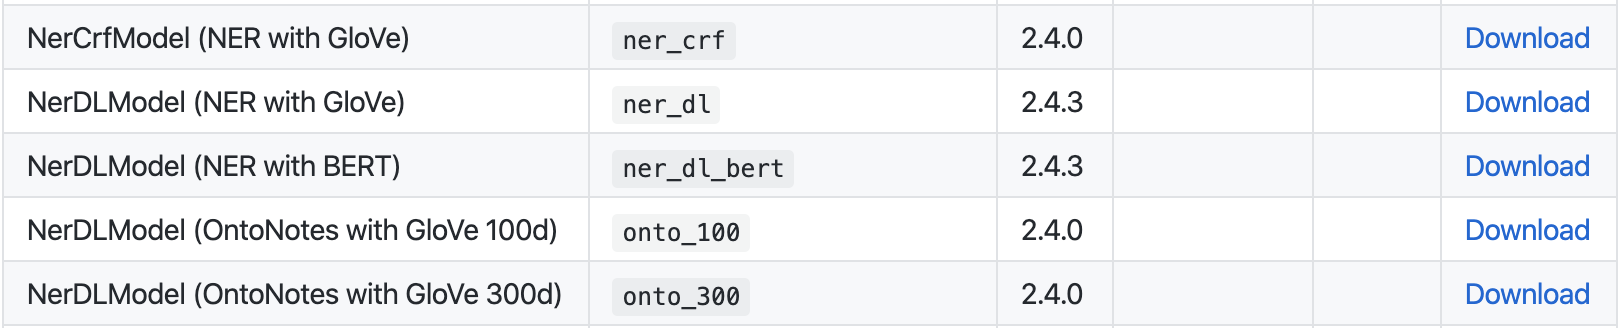

### Public NER (CoNLL 2003)


Entities

``` PERSON, LOCATION, ORGANIZATION, MISC ```

In [5]:
public_ner = NerDLModel.pretrained("ner_dl", 'en') \
          .setInputCols(["document", "token", "embeddings"]) \
          .setOutputCol("ner")

ner_dl download started this may take some time.
Approximate size to download 13.6 MB
[OK!]


In [6]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")

# ner_dl model is trained with glove_100d. So we use the same embeddings in the pipeline
glove_embeddings = WordEmbeddingsModel.pretrained('glove_100d').\
  setInputCols(["document", 'token']).\
  setOutputCol("embeddings")

nlpPipeline = Pipeline(stages=[
 documentAssembler, 
 tokenizer,
 glove_embeddings,
 public_ner
 ])

empty_df = spark.createDataFrame([['']]).toDF("text")

pipelineModel = nlpPipeline.fit(empty_df)


glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[OK!]


In [7]:
result = pipelineModel.transform(news_df.limit(10))

result_df = result.select(F.explode(F.arrays_zip('token.result', 'ner.result')).alias("cols")) \
.select(F.expr("cols['0']").alias("token"),
        F.expr("cols['1']").alias("ner_label"))

result_df.show(50, truncate=100)



+------------+---------+
|       token|ner_label|
+------------+---------+
|      Unions|        O|
|representing|        O|
|     workers|        O|
|          at|        O|
|      Turner|    B-ORG|
|      Newall|    I-ORG|
|         say|        O|
|        they|        O|
|         are|        O|
|           '|        O|
|disappointed|        O|
|           '|        O|
|       after|        O|
|       talks|        O|
|        with|        O|
|    stricken|        O|
|      parent|        O|
|        firm|        O|
|     Federal|    B-ORG|
|       Mogul|    I-ORG|
|           .|        O|
|     TORONTO|    B-LOC|
|           ,|        O|
|      Canada|    B-LOC|
|           A|        O|
|      second|        O|
|        team|        O|
|          of|        O|
|  rocketeers|        O|
|   competing|        O|
|         for|        O|
|         the|        O|
|      #36;10|        O|
|     million|        O|
|      Ansari|   B-MISC|
|           X|   I-MISC|
|       Prize|   I-MISC|


### NerDL OntoNotes 100D

Entities

``` 'CARDINAL', 'DATE', 'EVENT', 'FAC', 'GPE', 'LANGUAGE', 'LAW', 'LOC', 'MONEY', 'NORP', 'ORDINAL', 'ORG', 'PERCENT', 'PERSON', 'PRODUCT', 'QUANTITY', 'TIME', 'WORK_OF_ART' ```

In [8]:
onto_ner = NerDLModel.pretrained("onto_100", 'en') \
          .setInputCols(["document", "token", "embeddings"]) \
          .setOutputCol("ner")

nlpPipeline = Pipeline(stages=[
 documentAssembler, 
 tokenizer,
 glove_embeddings,
 onto_ner
 ])

empty_df = spark.createDataFrame([['']]).toDF("text")

pipelineModel = nlpPipeline.fit(empty_df)


onto_100 download started this may take some time.
Approximate size to download 13.5 MB
[OK!]


In [9]:
result = pipelineModel.transform(news_df.limit(10))

result_df = result.select(F.explode(F.arrays_zip('token.result', 'ner.result')).alias("cols")) \
.select(F.expr("cols['0']").alias("token"),
        F.expr("cols['1']").alias("ner_label"))

result_df.show(50, truncate=100)


+------------+-------------+
|       token|    ner_label|
+------------+-------------+
|      Unions|            O|
|representing|            O|
|     workers|            O|
|          at|            O|
|      Turner|        B-ORG|
|      Newall|        I-ORG|
|         say|            O|
|        they|            O|
|         are|            O|
|           '|            O|
|disappointed|            O|
|           '|            O|
|       after|            O|
|       talks|            O|
|        with|            O|
|    stricken|            O|
|      parent|            O|
|        firm|            O|
|     Federal|        B-ORG|
|       Mogul|        I-ORG|
|           .|            O|
|     TORONTO|        B-GPE|
|           ,|            O|
|      Canada|        B-GPE|
|           A|            O|
|      second|    B-ORDINAL|
|        team|            O|
|          of|            O|
|  rocketeers|            O|
|   competing|            O|
|         for|            O|
|         the|

### Getting the NER chunks with NER Converter

In [11]:

ner_converter = NerConverter() \
  .setInputCols(["document", "token", "ner"]) \
  .setOutputCol("ner_chunk")

nlpPipeline = Pipeline(stages=[
 documentAssembler, 
 tokenizer,
 glove_embeddings,
 onto_ner,
 ner_converter
 ])

empty_df = spark.createDataFrame([['']]).toDF("text")

pipelineModel = nlpPipeline.fit(empty_df)

result = pipelineModel.transform(news_df.limit(10))



In [14]:
result.select(F.explode(F.arrays_zip('ner_chunk.result', 'ner_chunk.metadata')).alias("cols")) \
.select(F.expr("cols['0']").alias("chunk"),
        F.expr("cols['1']['entity']").alias("ner_label")).show(truncate=False)

+-----------------------------------+-----------+
|chunk                              |ner_label  |
+-----------------------------------+-----------+
|Turner   Newall                    |ORG        |
|Federal Mogul                      |ORG        |
|TORONTO                            |GPE        |
|Canada                             |GPE        |
|second                             |ORDINAL    |
|#36;10 million                     |CARDINAL   |
|Ansari X Prize                     |WORK_OF_ART|
|first                              |ORDINAL    |
|the University of Louisville       |ORG        |
|Mike Fitzpatrick                   |PERSON     |
|the day                            |DATE       |
|Southern California's              |LOC        |
|Friday                             |DATE       |
|first                              |ORDINAL    |
|British                            |NORP       |
|Department for Education and Skills|ORG        |
|""Music Manifesto""                |WORK_OF_ART|


In [20]:
# fullAnnotate in LightPipeline

light_model = LightPipeline(pipelineModel)

light_result = light_model.fullAnnotate('Unions representing workers at Turner Newall say they are disappointed after talks with stricken parent firm Federal Mogul and Mike Fitzpatrick in Canada.')


chunks = []
entities = []

for n in light_result[0]['ner_chunk']:
        
    chunks.append(n.result)
    entities.append(n.metadata['entity']) 
    
    
import pandas as pd

df = pd.DataFrame({'chunks':chunks, 'entities':entities})

df

,chunks,entities
0,Turner Newall,ORG
1,Federal Mogul,ORG
2,Mike Fitzpatrick,PERSON
3,Canada,GPE
